# BPMF
## netflix data 구현

In [11]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt

from numpy.random import multivariate_normal
from scipy.stats import wishart

## 데이터 전처리

### netflix data 불러오기

In [12]:
ratings = pd.read_csv('./data/netflix_data_small.csv')
ratings.head(10)

,user_id,movie_id,rating
0,2442,1,3.0
1,1719610,1,2.0
2,1011918,1,4.0
3,479924,1,5.0
4,2389367,1,1.0
5,563962,1,5.0
6,369646,1,5.0
7,1430587,1,4.0
8,305344,1,1.0
9,389872,1,2.0


In [14]:
ratings['rating'].mean()

3.591302190401928

In [15]:
ratings['rating'].std()

1.0952602247926584

<AxesSubplot:>

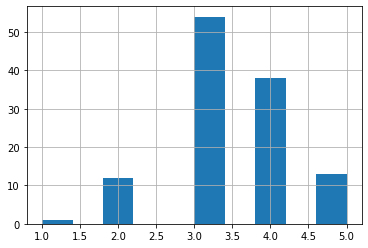

In [16]:
ratings.loc[ratings['user_id']==2442,'rating'].hist()

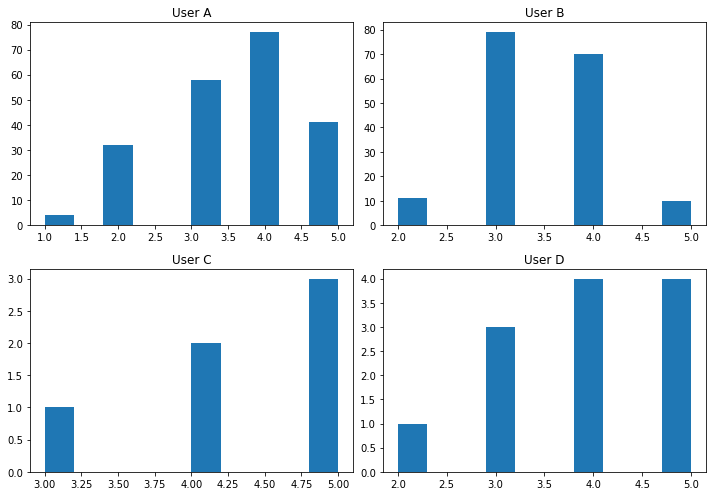

In [17]:
np.random.seed(123)
random_user_list = np.random.choice(ratings['user_id'].unique(),4)
fig, axs = plt.subplots(2,2, figsize=(10,7))
axs[0,0].hist(ratings.loc[ratings['user_id']==random_user_list[0],'rating'])
axs[0,0].set_title("User A")

axs[0,1].hist(ratings.loc[ratings['user_id']==random_user_list[1],'rating'])
axs[0,1].set_title("User B")

axs[1,0].hist(ratings.loc[ratings['user_id']==random_user_list[2],'rating'])
axs[1,0].set_title("User C")

axs[1,1].hist(ratings.loc[ratings['user_id']==random_user_list[3],'rating'])
axs[1,1].set_title("User D")

fig.tight_layout()

### train, test 분리

In [18]:
# train test 분리
from sklearn.utils import shuffle
np.random.seed(123)
TRAIN_SIZE = 0.75
ratings = shuffle(ratings, random_state=1)
cutoff = int(TRAIN_SIZE * len(ratings))
ratings_train = ratings.iloc[:cutoff]
ratings_test = ratings.iloc[cutoff:]

In [19]:
R_temp = ratings.pivot(index='user_id', columns='movie_id', values='rating').fillna(0)
R = np.array(R_temp)
R_test = np.zeros(R.shape)

item_id_index = []
index_item_id = []
for i, one_id in enumerate(R_temp):
    item_id_index.append([one_id, i])
    index_item_id.append([i, one_id])
item_id_index = dict(item_id_index)
index_item_id = dict(index_item_id)  

user_id_index = []
index_user_id = []
for i, one_id in enumerate(R_temp.T):
    user_id_index.append([one_id, i])
    index_user_id.append([i, one_id])
user_id_index = dict(user_id_index)
index_user_id = dict(index_user_id)

In [20]:
test_set = []
for i in range(len(ratings_test)):      # test 데이터에 있는 각 데이터에 대해서
    x = user_id_index[ratings_test.iloc[i, 0]]
    y = item_id_index[ratings_test.iloc[i, 1]]
    z = ratings_test.iloc[i, 2]
    test_set.append([x, y, z])
    R[x, y] = 0                    # Setting test set ratings to 0
    R_test[x, y] = z

In [23]:
print(R.shape, R_test.shape)

(10000, 4497) (10000, 4497)


## BPMF 구현

In [25]:
def BPMF(R, R_test, U_in, V_in, T, D, lowest_rating, highest_rating,
         mu_0=None, Beta_0=None, W_0=None, nu_0=None, seed=None):

    def Normal_Wishart(mu_0, lamb, W, nu, seed=None):
        """Function extracting a Normal_Wishart random variable"""
        Lambda = wishart(df=nu, scale=W, seed=seed).rvs()
        cov = np.linalg.inv(lamb * Lambda)
        mu = multivariate_normal(mu_0, cov)
        return mu, Lambda, cov

    def ranked(i, j):  # function telling if user i ranked movie j in the train dataset.
        if R[i, j] != 0:
            return True
        else:
            return False

    def ranked_test(i, j):  # function telling if user i ranked movie j in the test dataset.
        if R_test[i, j] != 0:
            return True
        else:
            return False

    N = R.shape[0] ; M = R.shape[1]
    U_old = np.array(U_in) ; V_old = np.array(V_in)
    R_pred_sum = np.zeros((N, M))
    train_rmse_list = []
    test_rmse_list = []
    train_epoch_list = []

    ### mcmc sample list
    ## predictions
    mcmc_samples_Rij = []
    ## hyperparams
    #mcmc_samples_mu_u = np.array([])
    #mcmc_samples_Lambda_U = np.array([])
    #mcmc_samples_mu_v = np.array([])
    #mcmc_samples_Lambda_V = np.array([])
    ## params
    mcmc_samples_U_new = []
    mcmc_samples_V_new = []

    # initialize now the hierarchical priors:
    alpha = 2  # observation noise, they put it = 2 in the paper
    mu_u = np.zeros((D, 1))
    mu_v = np.zeros((D, 1))
    Lambda_U = np.eye(D)
    Lambda_V = np.eye(D)

    # COUNT HOW MAY PAIRS ARE IN THE TEST AND TRAIN SET:
    pairs_train = (R != np.zeros((R.shape[0], R.shape[1]))).sum()
    pairs_test = (R_test != np.zeros((R_test.shape[0], R_test.shape[1]))).sum()

    # SET THE DEFAULT VALUES for Wishart distribution
    # we assume that parameters for both U and V are the same.

    if mu_0 is None:
        mu_0 = np.zeros(D)
    if nu_0 is None:
        nu_0 = D
    if Beta_0 is None:
        Beta_0 = 2
    if W_0 is None:
        W_0 = np.eye(D)    

    ## Gibbs sampling
    np.random.seed(seed)
    for t in range(T):
        """ SAMPLE HYPERPARAMETERS """
        Beta_0_star = Beta_0 + N
        nu_0_star = nu_0 + N
        W_0_inv = np.linalg.inv(W_0)

        ### user hyperparameters : mu_U, Lambda_U
        U_average = np.sum(U_old, axis=1) / N
        dot_temp = np.zeros((D,D))
        for i in range(N):
            U_dev = (U_old[:,i] - U_average).reshape((D,1))
            dot_temp += np.dot(U_dev, np.transpose(U_dev))
        S_bar_U = dot_temp / N

        mu_0_star_U = (Beta_0 * mu_0 + N * U_average) / (Beta_0 + N)
        W_0_star_U_inv = W_0_inv + N * S_bar_U + Beta_0 * N / (Beta_0 + N) * np.dot(
            np.transpose(np.array(mu_0 - U_average, ndmin=2)), 
            np.array((mu_0 - U_average), ndmin=2))
        W_0_star_U = np.linalg.inv(W_0_star_U_inv)

        # sample from Gaussian-Wishart distribution
        mu_U, Lambda_U, cov_U = Normal_Wishart(mu_0_star_U, Beta_0_star, 
                                               W_0_star_U, nu_0_star, seed=seed)

        ### movie hyperparameters : mu_V, Lambda_V
        V_average = np.sum(V_old, axis=1) / M
        dot_temp = np.zeros((D,D))
        for j in range(M):
            V_dev = (V_old[:,j] - V_average).reshape((D,1))
            dot_temp += np.dot(V_dev, np.transpose(V_dev))
        S_bar_V = dot_temp / M

        mu_0_star_V = (Beta_0 * mu_0 + M * V_average) / (Beta_0 + M)
        W_0_star_V_inv = W_0_inv + M * S_bar_V + Beta_0 * M / (Beta_0 + M) * np.dot(
            np.transpose(np.array(mu_0 - V_average, ndmin=2)), 
            np.array((mu_0 - V_average), ndmin=2))
        W_0_star_V = np.linalg.inv(W_0_star_V_inv)

        # sample from Gaussian-Wishart distribution
        mu_V, Lambda_V, cov_V = Normal_Wishart(mu_0_star_V, Beta_0_star, 
                                               W_0_star_V, nu_0_star, seed=seed)


        """ SAMPLE PARAMETERS : U, V """
        U_new = np.zeros((D,N))
        V_new = np.zeros((D,M))

        ## sample user features
        for i in range(N):
            vvt_temp = np.zeros((D,D))
            vr_temp = np.zeros(D)
            for j in range(M):
                if ranked(i,j):
                    vvt_temp += np.dot(V_old[:,j].reshape((D,1)), 
                                       np.transpose(V_old[:,j].reshape((D,1))))
                    vr_temp += V_old[:,j]*R[i,j]
            Lambda_i_star_U = Lambda_U + alpha * vvt_temp
            Lambda_i_star_U_inv = np.linalg.inv(Lambda_i_star_U)
            mu_i_star = np.dot( Lambda_i_star_U_inv, alpha*vr_temp + np.dot(Lambda_U, mu_U))

            # sample new U
            new_U_i = multivariate_normal(mu_i_star, Lambda_i_star_U_inv) # Dx1
            U_new[:,i] = new_U_i

        ## sample movie features    
        for j in range(M):
            uut_temp = np.zeros((D,D))
            ur_temp = np.zeros(D)
            for i in range(N):
                if ranked(i,j):
                    uut_temp += np.dot(U_new[:, i].reshape((D,1)), 
                                       np.transpose(U_new[:, i].reshape((D,1))))
                    ur_temp += U_new[:, i]*R[i,j]
            Lambda_j_star_V = Lambda_V + alpha * uut_temp
            Lambda_j_star_V_inv = np.linalg.inv(Lambda_j_star_V)
            mu_j_star = np.dot( Lambda_j_star_V_inv, alpha*ur_temp + np.dot(Lambda_V, mu_V) )

            # sample new V
            new_V_j = multivariate_normal(mu_j_star, Lambda_j_star_V_inv) # Dx1
            V_new[:,j] = new_V_j

        # update U, V
        U_old = np.array(U_new)
        V_old = np.array(V_new)
        
        mcmc_samples_U_new.append(U_new[1,5])
        mcmc_samples_V_new.append(V_new[3,5])

        R_step = np.dot(np.transpose(U_new), V_new)
        for i in range(N):  # reduce all the predictions to the correct ratings range.
            for j in range(M):
                if R_step[i, j] > highest_rating:
                    R_step[i, j] = highest_rating
                elif R_step[i, j] < lowest_rating:
                    R_step[i, j] = lowest_rating

        mcmc_samples_Rij.append(R_step[1,3])

        R_pred_sum += R_step
        k = t+1 # num iter
        R_pred = R_pred_sum / k

        # train RMSE
        train_err = 0
        for i in range(N):
            for j in range(M):
                if ranked(i, j):
                    train_err += (R_pred[i,j] - R[i,j])**2 # sum of squared error
        train_rmse = np.sqrt(train_err / pairs_train)
        train_rmse_list.append(train_rmse)
        print("\n Training RMSE at iteration ", k, " :   ", "{:.4}".format(train_rmse))

        # test RMSE
        test_err = 0
        for i in range(N):
            for j in range(M):
                if ranked_test(i, j):
                    test_err += (R_pred[i,j] - R_test[i,j])**2 # sum of squared error
        test_rmse = np.sqrt(test_err / pairs_test)
        test_rmse_list.append(test_rmse)
        print("Test RMSE at iteration ", k, " :   ", "{:.4}".format(test_rmse))

        train_epoch_list.append(k)
        
    return R_pred, train_rmse_list, test_rmse_list, train_epoch_list, mcmc_samples_Rij, mcmc_samples_U_new, mcmc_samples_V_new

## train

#### 초기값 설정

In [26]:
'''# PMF 결과 추정된 U,V를 initial value로 사용
U_in = np.load("U_02.npy")
V_in = np.load("V_02.npy")'''

'# PMF 결과 추정된 U,V를 initial value로 사용\nU_in = np.load("U_02.npy")\nV_in = np.load("V_02.npy")'

In [27]:
D=10
mu_u = np.zeros((D, 1)) ; mu_v = np.zeros((D, 1))
N = R.shape[0] ; M = R.shape[1]
U_in=np.zeros((D, N)) ; V_in=np.zeros((D, M))
np.random.seed(123)
for i in range(N):
    U_in[:,i] = np.random.normal(mu_u, size=(D,1)).reshape(D)

for j in range(M):
    V_in[:,j] = np.random.normal(mu_v, size=(D,1)).reshape(D)

In [28]:
import time
start = time.time()

result = BPMF(R, R_test, U_in, V_in, T=40, D=10, 
     lowest_rating=1, highest_rating=5, 
     mu_0=None, Beta_0=None, W_0=None, nu_0=None, seed=123)

print(time.time()-start)


 Training RMSE at iteration  1  :    2.212
Test RMSE at iteration  1  :    2.414

 Training RMSE at iteration  2  :    1.378
Test RMSE at iteration  2  :    1.564

 Training RMSE at iteration  3  :    1.097
Test RMSE at iteration  3  :    1.268

 Training RMSE at iteration  4  :    0.9687
Test RMSE at iteration  4  :    1.131

 Training RMSE at iteration  5  :    0.9004
Test RMSE at iteration  5  :    1.057

 Training RMSE at iteration  6  :    0.8605
Test RMSE at iteration  6  :    1.013

 Training RMSE at iteration  7  :    0.8357
Test RMSE at iteration  7  :    0.9835

 Training RMSE at iteration  8  :    0.8198
Test RMSE at iteration  8  :    0.9635

 Training RMSE at iteration  9  :    0.8094
Test RMSE at iteration  9  :    0.9491

 Training RMSE at iteration  10  :    0.8026
Test RMSE at iteration  10  :    0.9383

 Training RMSE at iteration  11  :    0.7982
Test RMSE at iteration  11  :    0.9303

 Training RMSE at iteration  12  :    0.7954
Test RMSE at iteration  12  :    0.

In [29]:
R_pred, train_rmse_list, test_rmse_list, train_epoch_list, mcmc_samples_Rij, mcmc_samples_U_new, mcmc_samples_V_new = result

## 결과 시각화

Text(0, 0.5, 'RMSE')

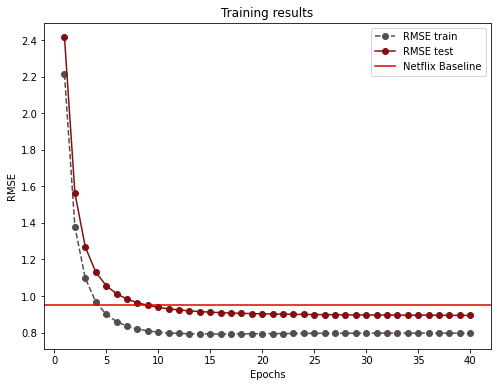

In [32]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.title('Training results')
plt.plot(train_epoch_list, train_rmse_list, label='RMSE train', 
         color='#564d4d', marker='o', linestyle='--')
plt.plot(train_epoch_list, test_rmse_list, label='RMSE test', 
         color='#831010', marker='o')
plt.axhline(0.9514, color='#db0000', label='Netflix Baseline')

plt.legend()
plt.xlabel('Epochs')
plt.ylabel('RMSE')

Text(0, 0.5, 'R')

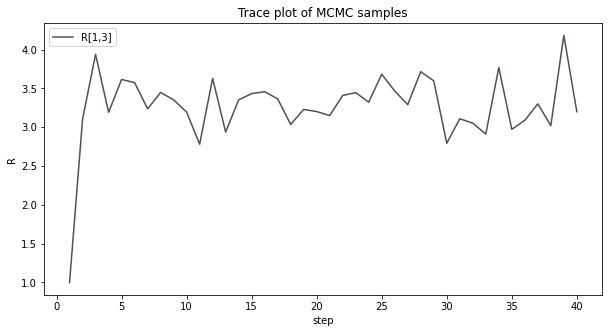

In [33]:
plt.figure(figsize=(10, 5))
plt.title('Trace plot of MCMC samples')
plt.plot(train_epoch_list, mcmc_samples_Rij, label='R[1,3]', 
         color='#564d4d')
plt.legend()
plt.xlabel('step')
plt.ylabel('R')

# 예측 결과 확인

In [35]:
df_movies = pd.read_csv('movie_titles.csv', encoding = "ISO-8859-1", header = None, names = ['movie_id', 'year', 'title'])
df_movies.drop('year', axis=1, inplace=True)
df_movies.head()

,movie_id,title
0,1,Dinosaur Planet
1,2,Isle of Man TT 2004 Review
2,3,Character
3,4,Paula Abdul's Get Up & Dance
4,5,The Rise and Fall of ECW


In [36]:
user_dict = dict(zip(ratings.user_id.unique(), range(ratings.user_id.nunique())))
#user_dict = dict(zip(range(ratings.user_id.nunique()),ratings.user_id.unique()))
#movie_dict = dict(zip(ratings.movie_id.unique(), range(ratings.movie_id.nunique())))
#ratings_dict = ratings.replace({'user_id':user_dict})
#ratings_dict = ratings_dict.replace({'movie_id':movie_dict})

### user_id=2442 유저에 대한 예측값 확인

In [37]:
R_pred_2442 = pd.DataFrame(R_pred[user_dict[2442]],np.arange(1,M+1)).reset_index()
R_pred_2442.columns = ['movie_id','rating_pred']
R_pred_2442 = pd.merge(R_pred_2442, df_movies, how='left', on='movie_id')
R_pred_2442

,movie_id,rating_pred,title
0,1,3.102412,Dinosaur Planet
1,2,2.887548,Isle of Man TT 2004 Review
2,3,3.511813,Character
3,4,3.014915,Paula Abdul's Get Up & Dance
4,5,3.537195,The Rise and Fall of ECW
...,...,...,...
4492,4493,3.629701,Ju-on: The Grudge
4493,4494,3.094832,Cartoon Crazys: Vol. 1
4494,4495,2.957297,Clifford: Happy Birthday Clifford / Puppy Love
4495,4496,3.181694,Farewell My Concubine


#### user 2442의 취향

In [38]:
R_result = pd.merge(R_pred_2442, ratings[ratings['user_id']==2442].drop('user_id',axis=1), how='left', on='movie_id')
R_result = R_result[R_result['rating'].isna()==False]
R_result = R_result[['movie_id','title','rating','rating_pred']].reset_index(drop=True)

R_result.sort_values(by='rating', ascending=False).head(10)

,movie_id,title,rating,rating_pred
18,1084,Walking with Prehistoric Beasts,5.0,2.649816
73,2862,The Silence of the Lambs,5.0,3.078828
23,1391,Yanni: Live at the Acropolis,5.0,3.008299
78,3113,Dante's Peak,5.0,3.252302
79,3184,Desert Hearts,5.0,3.160749
26,1470,Bend It Like Beckham,5.0,2.993537
27,1482,Beyond Borders,5.0,3.272943
92,3671,Laughing Matters,5.0,3.303395
57,2452,Lord of the Rings: The Fellowship of the Ring,5.0,2.928999
31,1709,Clash of the Titans,5.0,3.504033


In [40]:
R_result.head(10)

,movie_id,title,rating,rating_pred
0,1,Dinosaur Planet,3.0,3.102412
1,30,Something's Gotta Give,3.0,3.821087
2,188,Dead Birds,3.0,2.546090
3,191,X2: X-Men United,4.0,3.857685
4,283,If These Walls Could Talk,4.0,3.682491
5,457,Kill Bill: Vol. 2,3.0,3.300550
6,486,Journey to the Center of the Earth,4.0,3.470178
7,514,Santana: Supernatural Live,3.0,3.385765
8,528,The Hitchhiker's Guide to the Galaxy,4.0,2.127235
9,594,By Hook or By Crook,2.0,3.015638


#### user 2442가 좋아할만한 영화는?

In [39]:
R_result_recom = pd.merge(R_pred_2442, ratings[ratings['user_id']==2442].drop('user_id',axis=1), how='left', on='movie_id')
R_result_recom = R_result_recom[R_result_recom['rating'].isna()==True]
R_result_recom = R_result_recom[['movie_id','title','rating','rating_pred']].reset_index(drop=True)

R_result_recom.sort_values(by='rating_pred', ascending=False).head(10)

,movie_id,title,rating,rating_pred
2858,2937,The Gate,NaN,4.728234
3364,3454,Kenny Chesney: Greatest Hits,NaN,4.687521
2998,3077,Turbulence,NaN,4.661542
2862,2941,Love Me Tonight,NaN,4.655401
1232,1255,Better Off Dead,NaN,4.641759
1465,1494,Appalachian Journey: Yo-Yo Ma/Edgar Meyer/Mark...,NaN,4.629214
2393,2451,Stealing Candy,NaN,4.601193
265,270,Sex and the City: Season 4,NaN,4.598906
3857,3960,Pollyanna,NaN,4.591619
4308,4425,Miranda (Tinto Brass),NaN,4.586969
